In [1]:
import sys
sys.path.append("..")  # Ensure project root is found

# Import configurations
from configs.plot_config import apply_plot_settings
from configs.math_functions import F, lognormal
from configs.parameters import *
from configs.filenames import *

import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import numpy as np
import os

C = float(os.getenv("C", C))
sig = float(os.getenv("sig", sig))
itr = 180000
E0 = int(os.getenv("E0", E0))
I0 = int(os.getenv("I0", I0))

print(f"📢 Using parameters: C={C}, sig={sig}, itr={itr}, E0={E0}, I0={I0}")

📢 Using parameters: C=0.01, sig=0.1, itr=180000, E0=0, I0=0


In [2]:
t = np.linspace(0, (itr+1) * dt, itr+1)

EI1 = np.ones((2, itr+1)) * (-3)
EI2 = np.ones((2, itr+1))

synaptic_input1 = np.zeros((2, itr+1))
synaptic_input2 = np.zeros((2, itr+1))

# Simulation loop
for n in range(itr):
    s = np.arange(1, n+1)  # Opening array for delay function
    lognorm = lognormal(s * dt, np.log(tau), sig)  # Compute Lognormal delay kernel
    
    # Compute synaptic integrals using vectorized operations
    if n > 0:
        EI1_backwards = np.flip(EI1[:, 1:n+1], axis=1)
        EI2_backwards = np.flip(EI2[:, 1:n+1], axis=1)
        
        integral1 = lognorm * EI1_backwards
        integral2 = lognorm * EI2_backwards

        synaptic_input1[:, n] = np.sum(integral1, axis=1) * dt
        synaptic_input2[:, n] = np.sum(integral2, axis=1) * dt

    # Update dynamics for both systems
    EI1[:, n+1] = EI1[:, n] + dt * np.array([
        -EI1[0, n] + wee * F(synaptic_input1[0, n]) - wei * F(synaptic_input1[1, n]) + ie + C * EI2[0, n],
        -EI1[1, n] + wie * F(synaptic_input1[0, n]) - wii * F(synaptic_input1[1, n]) + ii + C * EI2[1, n]
    ])
    
    EI2[:, n+1] = EI2[:, n] + dt * np.array([
        -EI2[0, n] + wee * F(synaptic_input2[0, n]) - wei * F(synaptic_input2[1, n]) + ie + C * EI1[0, n],
        -EI2[1, n] + wie * F(synaptic_input2[0, n]) - wii * F(synaptic_input2[1, n]) + ii + C * EI1[1, n]
    ])
    
    if n % 1000 == 0: 
        print(f"Iteration {n}/{itr}", end="\r")

# Extract results
synEE1, synII1 = synaptic_input1
synEE2, synII2 = synaptic_input2
EE1, II1 = EI1
EE2, II2 = EI2

# Save data in /data/
data = np.column_stack((t, synEE1, synEE2, synII1, synII2, EE1, EE2, II1, II2))
output_dir = "../data/"

params = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "Coupled", **params)
savefile = os.path.join(output_dir, filename)
np.save(savefile, data, allow_pickle=True)

print(f"✅ Data saved to {savefile}")

✅ Data saved to ../data/Coupled_WCM_LOGNORMAL_delay_itr=180000_dt=0.005_tau=1_sig=0.1_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_C=0.01.npy


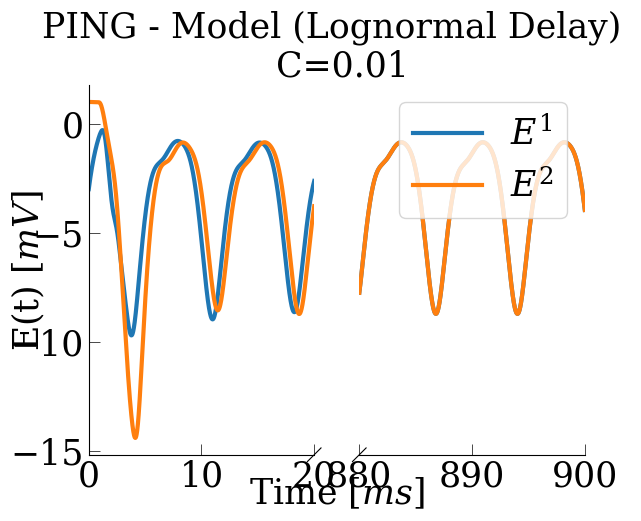

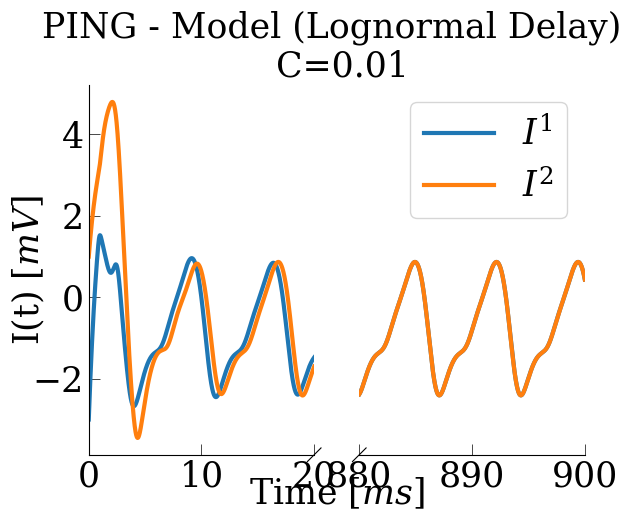

In [3]:
apply_plot_settings()

data = np.load(savefile, allow_pickle=True)
t, synEE1, synEE2, synII1, synII2, EE1, EE2, II1, II2 = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5], data[:, 6], data[:, 7], data[:, 8]

xlims = ((0, 20), (880, 900))

# Plot Excitatory Neurons
bax = brokenaxes(xlims=xlims, hspace=.05)  # No need to create fig, ax manually
bax.plot(t, EE1, linewidth=3, label='$E^1$')
bax.plot(t, EE2, linewidth=3, label='$E^2$')

bax.set_xlabel('Time $[ms]$')
bax.set_ylabel('E(t) $[mV]$')
bax.set_title(f'PING - Model (Lognormal Delay) \n C={C}')
bax.tick_params(direction='in', length=8, width=0.5, colors='black')
bax.legend(loc='best')

plt.show()

# Plot Inhibitory Neurons
bax = brokenaxes(xlims=xlims, hspace=.05)
bax.plot(t, II1, linewidth=3, label='$I^1$')
bax.plot(t, II2, linewidth=3, label='$I^2$')

bax.set_xlabel('Time $[ms]$')
bax.set_ylabel('I(t) $[mV]$')
bax.set_title(f'PING - Model (Lognormal Delay) \n C={C}')
bax.tick_params(direction='in', length=8, width=0.5, colors='black')
bax.legend(loc='best')

plt.show()
